<a href="https://colab.research.google.com/github/nguyenanhtienabcd/AIO2024_EXERCISE/blob/feature%2FMODULE5-WEEK3/m05w03_ex3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Resize
from torchvision.io import read_image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [5]:
!unzip -q '/content/FER-2013.zip' -d '/content/FER-2013'

In [ ]:
#  đặt giá trị ngẫu nhiên cho hệ thống
# với các lần lặp là cố định
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

In [6]:
train_dir = 'FER-2013/test'
test_dir = 'FER-2013/train'

classes = os.listdir(train_dir)

label2idx = {cls: idx for idx, cls in enumerate(classes)}
idx2label = {idx: cls for idx, cls in label2idx.items()}

In [7]:
test_image_path = '/content/FER-2013/train/angry/Training_10118481.jpg'
image = cv2.imread(test_image_path)
img_height, img_width = 128, 128
print(f'Height: {img_height}, Width: {img_width}')

Height: 128, Width: 128


In [8]:
# Dataset class
class ImageDataset(Dataset):
    def __init__(self, img_dir, norm, label2idx, split='train', train_ratio=0.8):
        self.resize = Resize((img_height, img_width))
        self.norm = norm
        self.split = split
        self.train_ratio = train_ratio
        self.img_dir = img_dir
        self.label2idx = label2idx
        self.img_paths, self.img_labels = self.read_img_files()

        if split in ['train', 'val'] and 'train' in img_dir.lower():
            train_data, val_data = train_test_split(
                list(zip(self.img_paths, self.img_labels)),
                train_size=train_ratio,
                random_state=42,
                stratify=self.img_labels
            )
            if split == 'train':
                self.img_paths, self.img_labels = zip(*train_data)
            elif split == 'val':
                self.img_paths, self.img_labels = zip(*val_data)

    def read_img_files(self):
        img_paths = []
        img_labels = []
        for cls in self.label2idx.keys():
            for img in os.listdir(os.path.join(self.img_dir, cls)):
                img_paths.append(os.path.join(self.img_dir, cls, img))
                img_labels.append(cls)
        return img_paths, img_labels

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        cls = self.img_labels[idx]
        img = self.resize(read_image(img_path))
        img = img.type(torch.float32)
        label = self.label2idx[cls]
        if self.norm:
            img = (img / 127.5) - 1
        return img, label


In [9]:
# Tạo DataLoader
batch_size = 256

train_dataset = ImageDataset(train_dir, True, label2idx, split='train')
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = ImageDataset(train_dir, True, label2idx, split='val')
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = ImageDataset(test_dir, True, label2idx, split='test')
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

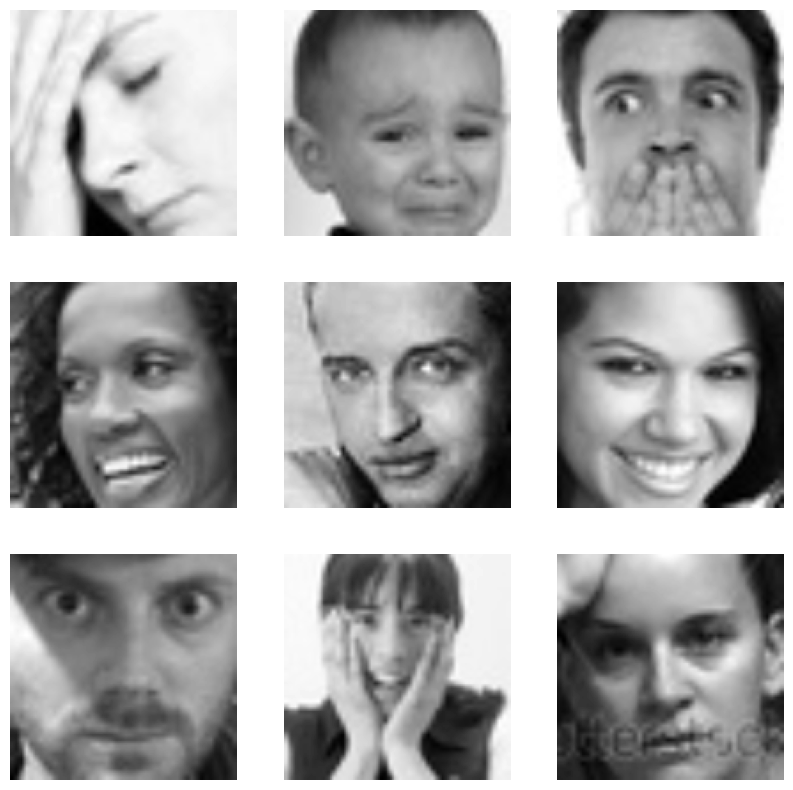

In [10]:
# Hiển thị dữ liệu
image_batch, label_batch = next(iter(train_loader))  # Lấy một batch từ DataLoader
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    minv = image_batch[i].numpy().min()
    maxv = image_batch[i].numpy().max()
    plt.imshow(np.squeeze(image_batch[i].numpy()), vmin=minv, vmax=maxv, cmap="gray")
    label = label_batch[i]
    #plt.title(idx2label[label.item()])  # Sử dụng .item() để lấy giá trị scalar
    plt.axis("off")
plt.show()

In [11]:
# MLP Model
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.linear2 = nn.Linear(hidden_dims, hidden_dims)
        self.linear3 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.relu(x)
        out = self.output(x)
        return out.squeeze(1)

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
input_dims = img_height * img_width
output_dims = len(classes)
hidden_dims = 64
lr = 1e-2

model = MLP(input_dims=input_dims, hidden_dims=hidden_dims, output_dims=output_dims).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)


In [14]:
# Compute accuracy
def compute_accuracy(y_hat, y_true):
    _, y_hat = torch.max(y_hat, dim=1)
    correct = (y_hat == y_true).sum().item()
    accuracy = correct / len(y_true)
    return accuracy


EPOCH 1: Training loss: 1.936	Validation loss: 1.920

EPOCH 2: Training loss: 1.911	Validation loss: 1.894

EPOCH 3: Training loss: 1.889	Validation loss: 1.867

EPOCH 4: Training loss: 1.862	Validation loss: 1.841

EPOCH 5: Training loss: 1.838	Validation loss: 1.820

EPOCH 6: Training loss: 1.821	Validation loss: 1.804

EPOCH 7: Training loss: 1.812	Validation loss: 1.791

EPOCH 8: Training loss: 1.793	Validation loss: 1.780

EPOCH 9: Training loss: 1.784	Validation loss: 1.771

EPOCH 10: Training loss: 1.779	Validation loss: 1.763

EPOCH 11: Training loss: 1.764	Validation loss: 1.755

EPOCH 12: Training loss: 1.763	Validation loss: 1.749

EPOCH 13: Training loss: 1.756	Validation loss: 1.742

EPOCH 14: Training loss: 1.747	Validation loss: 1.735

EPOCH 15: Training loss: 1.740	Validation loss: 1.727

EPOCH 16: Training loss: 1.732	Validation loss: 1.718

EPOCH 17: Training loss: 1.732	Validation loss: 1.712

EPOCH 18: Training loss: 1.717	Validation loss: 1.703

EPOCH 19: Training

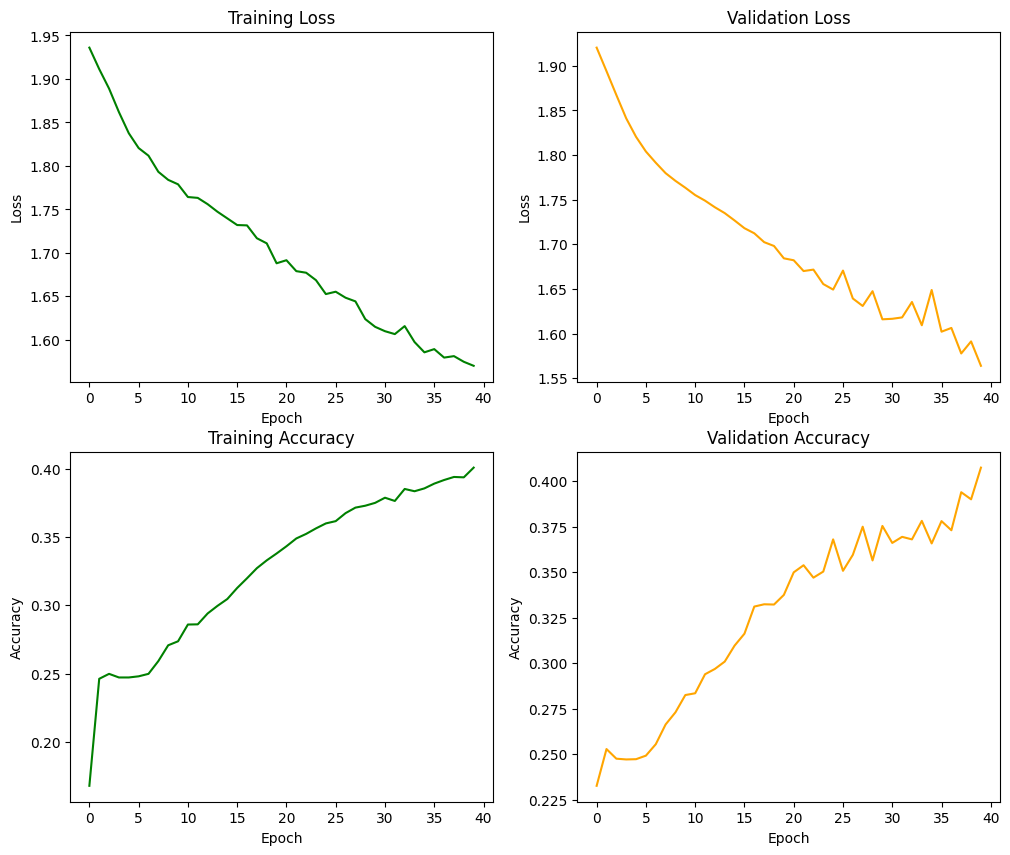

In [15]:
# Training loop
epochs = 40
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs):
    train_loss = 0.0
    train_target, train_predict = [], []
    model.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad()
        outputs = model(X_samples)
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_predict.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_acc = compute_accuracy(train_predict, train_target)
    train_accs.append(train_acc)

    val_loss = 0.0
    val_target, val_predict = [], []
    model.eval()
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model(X_samples)
            val_loss += criterion(outputs, y_samples).item()
            val_predict.append(outputs.cpu())
            val_target.append(y_samples.cpu())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict, val_target)
    val_accs.append(val_acc)

    print(f'\nEPOCH {epoch + 1}: Training loss: {train_loss:.3f}\tValidation loss: {val_loss:.3f}')

# Visualization of results
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accs, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

In [16]:
# Đánh giá mô hình
test_target = []
test_predict = []
model.eval()  # Chuyển mô hình sang chế độ đánh giá (evaluation mode)

with torch.no_grad():  # Vô hiệu hóa tính toán gradient
    for X_samples, y_samples in test_loader:
        # Chuyển dữ liệu sang GPU nếu có
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)

        # Dự đoán đầu ra từ mô hình
        outputs = model(X_samples)

        # Lưu trữ dự đoán và nhãn thực tế
        test_predict.append(outputs.cpu())  # Chuyển dự đoán về CPU
        test_target.append(y_samples.cpu())  # Chuyển nhãn về CPU

# Kết hợp các batch thành Tensor
test_predict = torch.cat(test_predict)
test_target = torch.cat(test_target)

# Tính toán độ chính xác
test_acc = compute_accuracy(test_predict, test_target)

# In kết quả
print('Evaluation on test set:')
print(f'Accuracy: {test_acc:.4f}')


Evaluation on test set:
Accuracy: 0.3605
